<img src="https://www.unir.net/wp-content/uploads/2019/11/Unir_2021_logo.svg" width="240" height="240" align="right"/>

<span>
<h2>Eliminación de ruido en imagenes de resonancia magnetica, mediante red neuronal convolucional CNN </h2> 
</span>

<p>
MobileNet: Aruitectura mas pequeña y rapida que la arquitectura VGG16 y otros modelos populares, este modelo es de baja potencia y baja latencia y se usa  para la clasificacion, deteccion y otras aplicaciones que resuelven las redes CNN. Este modelo es una buena opcion para dispositivos mobiles debido a su tamaño reducido, a continuacion se muestran algunas comparaciones entre modelos:

- Model     | Size   | Parameters

- VGG16     | 552 MB | 138.000.000
- MobileNet | 17  MB | 4.200.000

Sin embargo la exactitud del modelo MobileNet no es tan exacto como algunos de los grandes modelos. <a href="https://deeplizard.com/learn/video/OO4HD-1wRN8">Ver mas</a> 
</p>



## Instalar librerías

In [1]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

In [ ]:
!pip install tf-nightly

In [ ]:
!pip install h5py

In [ ]:
!pip install scikit-learn

In [ ]:
!pip uninstall tensorflow-directml

In [ ]:
!pip install matplotlib

In [ ]:
!pip install opencv-python

In [ ]:
!pip install pillow

In [2]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

## Importar librerías

In [36]:
import warnings
warnings.simplefilter('ignore', category=FutureWarning)
 
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import glob
import matplotlib.pyplot as plt
import cv2
import datetime
import time
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow.keras import Model, optimizers

## Configurar GPU con TensorFlow

NOTA: MobileNet es un modelo que no requiere GPU, en nuestro caso la usaremos para dar mas agilidad y mejor rendimiento al modelo ya que disponemos de 3 GPU.

In [5]:
tensorflow.test.is_gpu_available()
print("Num GPUs available", len(tensorflow.config.experimental.list_physical_devices('GPU')))

print(tensorflow.test.gpu_device_name())
print(tensorflow.test.is_gpu_available())

Num GPUs available 0
/device:DML:0
True


## Preparacion de imagenes

### Definir conjuntos de datos

#### Definir variables de entrenamiento, validacion y prueba

In [4]:
import os

# Entrenamiento
path_train = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/ENTRENAMIENTO/' 

# Validacion
path_val = 'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/VALIDACION/' 

# Pruebas
path_test = r'D:/ADNI - IDA/ADNI1_Complete 1Yr 1.5T/ADNI-PRE-PROCESAMIENTO/PRUEBA/'

### Definir conjuntos de datos en formato KERAS

In [55]:
# Generacion de lotes de datos para modelo en Keras en formato MobileNet

# Entrenamiento
train_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=path_train,
                         target_size=(224,224),
                         classes=['AD','CN','MCI'],
                         batch_size=10)

# Validacion
valid_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=path_val,
                         target_size=(224,224),
                         classes=['AD','CN','MCI'],
                         batch_size=10)

# Pruebas
test_batches = ImageDataGenerator(preprocessing_function=tensorflow.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=path_test,
                         target_size=(224,224),
                         classes=['AD','CN','MCI'],
                         batch_size=10, 
                         shuffle=False)

Found 5343 images belonging to 3 classes.
Found 1265 images belonging to 3 classes.
Found 63 images belonging to 3 classes.


In [7]:
assert train_batches.n == 5343 
assert valid_batches.n == 1265  
assert test_batches.n == 63
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3 

In [8]:
imgs, labels = next(train_batches)

In [9]:
"""Esta funcion mostrara imagenes en un grid con 1 fila y 10 columnas

Parameters
----------
list : numpy.ndarray
"""

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes =  axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img, cmap='Reds')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
imgs[0].shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

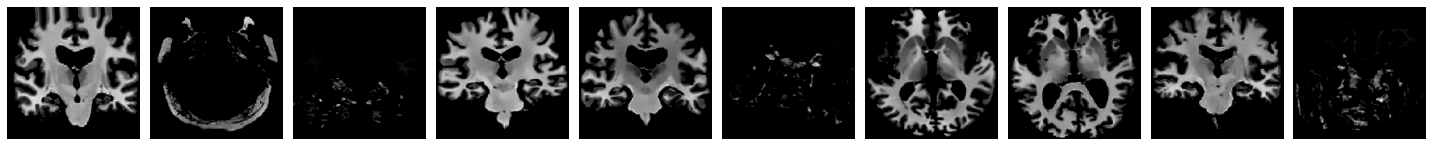

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]


In [11]:
plotImages(imgs)
print(labels)

## Construccion y entrenamiento del modelo CNN - MobileNet

In [12]:
with tensorflow.device('DML'):
    IMG_SHAPE = (224, 224, 3)
    base_model = tensorflow.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE, 
                                                                   include_top=False,
                                                                   weights='imagenet',
                                                                   pooling='avg')
    base_model.trainable = False

    inputs = tensorflow.keras.layers.Input(IMG_SHAPE)
    x = base_model(inputs)
    x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
    x = tensorflow.keras.layers.Dropout(0.2)(x)
    prediction  = tensorflow.keras.layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=prediction)
    model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 3,294,659
Trainable params: 65,795
Non-trainable params: 3,228,864
_________________________________________________________________


 ## Entrenamiento del modelo MobileNet

In [13]:
with tensorflow.device('DML'):
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.summary()   

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 64)                65600     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 3,294,659
Trainable params: 65,795
Non-trainable params: 3,228,864
_________________________________________________________________


In [14]:
with tensorflow.device('DML'):
    
    from keras.callbacks import EarlyStopping
    
    earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0, 
                             patience=5, # maximo epochs
                             verbose=1,
                             restore_best_weights=True,
                             mode='auto')
    
    model.fit(x=train_batches,
                  validation_data=valid_batches,
                  epochs=10,
                  verbose=2,
                  callbacks = [earlystopper])

Epoch 1/10
Epoch 1/10
535/535 - 33s - loss: 1.1160 - acc: 0.4134 - val_loss: 1.1547 - val_acc: 0.3636
Epoch 2/10
Epoch 1/10
535/535 - 31s - loss: 1.0055 - acc: 0.4930 - val_loss: 1.2099 - val_acc: 0.3415
Epoch 3/10
Epoch 1/10
535/535 - 31s - loss: 0.9767 - acc: 0.5149 - val_loss: 1.1463 - val_acc: 0.3660
Epoch 4/10
Epoch 1/10
535/535 - 31s - loss: 0.9508 - acc: 0.5381 - val_loss: 1.2160 - val_acc: 0.3510
Epoch 5/10
Epoch 1/10
535/535 - 31s - loss: 0.9327 - acc: 0.5448 - val_loss: 1.1709 - val_acc: 0.3652
Epoch 6/10
Epoch 1/10
535/535 - 32s - loss: 0.9118 - acc: 0.5574 - val_loss: 1.1520 - val_acc: 0.3747
Epoch 7/10
Epoch 1/10
535/535 - 32s - loss: 0.8784 - acc: 0.5806 - val_loss: 1.1018 - val_acc: 0.4142
Epoch 8/10
Epoch 1/10
535/535 - 31s - loss: 0.8731 - acc: 0.5828 - val_loss: 1.1652 - val_acc: 0.3850
Epoch 9/10
Epoch 1/10
535/535 - 31s - loss: 0.8562 - acc: 0.6002 - val_loss: 1.1654 - val_acc: 0.3889
Epoch 10/10
Epoch 1/10
535/535 - 31s - loss: 0.8337 - acc: 0.6128 - val_loss: 1.16

 ## Predicción con conjunto de pruebas

In [15]:
test_labels = test_batches.classes

In [16]:
predictions = model.predict(x = test_batches, verbose = 0)

In [17]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

In [18]:
test_batches.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

In [59]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None, normalize=False):
    """
    arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
     
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylim(len(target_names)-0.5, -0.5)
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.savefig(title + '.png', dpi=500, bbox_inches = 'tight')
    plt.show()
    
    
    
# a tuple for all the class names
target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

## Visualizar resultados del entrenamiento

In [20]:
print(model.history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [21]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.41343814, 0.49298146, 0.5148793, 0.5380872, 0.544825, 0.55736476, 0.5805727, 0.5828186, 0.60022455, 0.61276436]
[0.36363634, 0.34150198, 0.3660079, 0.35098815, 0.3652174, 0.37470356, 0.41422924, 0.38498023, 0.3889328, 0.38260868]
[1.1162583232483747, 1.0053694913299391, 0.9770659492320611, 0.9509262373869994, 0.9321245667908983, 0.9113417092878765, 0.8785055456102597, 0.872577992133516, 0.8559821177327676, 0.8337539427962706]
[1.1547450390387708, 1.2098803083727678, 1.146313747552436, 1.216030860979726, 1.1708569620537945, 1.1519680670865877, 1.101826011665224, 1.1652211448339027, 1.1653873634150649, 1.166605717553867]


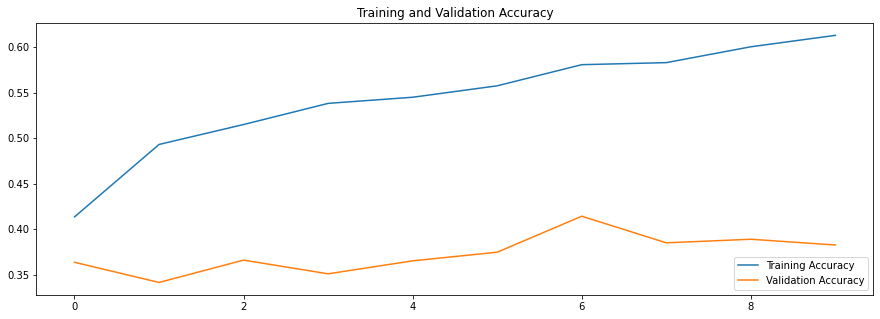

In [24]:
epochs_ft = 10
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(epochs_ft)

plt.figure(figsize=(15, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

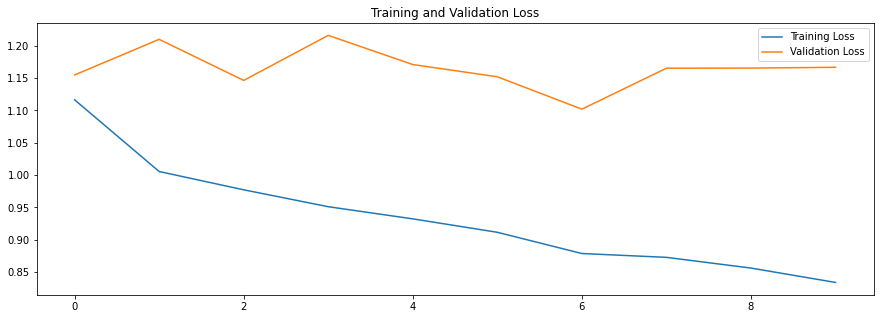

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=-1)
target_names = ('AD', 'CN', 'MCI')

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          AD       0.00      0.00      0.00        20
          CN       0.43      0.48      0.45        21
         MCI       0.44      0.73      0.55        22

    accuracy                           0.41        63
   macro avg       0.29      0.40      0.34        63
weighted avg       0.30      0.41      0.34        63



---
---
---

## Construcción y construir afinar el modelo CNN-MobileNet (Modelo afinado)

In [39]:
# Agregar la base de la parte superior del modelo (top)

nb_classes = 3

def add_top(base):
    x = base.output

    # Capa de grupo de promedio global
    #x = GlobalAveragePooling2D()(x)

    x = tensorflow.keras.layers.Dense(64, activation='relu')(x)
    x = tensorflow.keras.layers.Dropout(0.2)(x)
    
    # Capa regular densamente conectada
    x = Dense(512, activation='relu')(x)

    # Capa de salida
    predictions = Dense(nb_classes, activation='softmax')(x)

    return Model(inputs = base.input, outputs= predictions)

In [40]:
# Modelo de configuración afinado
def setup_model(model, trainable):
    # Congelar las capas no entrenables de la base del modelo
    for layer in model.layers[:(len(model.layers) - trainable)]:
        layer.trainable = False

    for layer in model.layers[(len(model.layers) - trainable):]:
        layer.trainable = True

    model.compile(
        loss='categorical_crossentropy',
        # Tasa de entrenamiento más lenta para el ajuste fino
        optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
        # optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy']
    )
    
    return model

In [41]:
# Configurar el modelo para volver a entrenar nuestra 
# capa superior más el bloque 13 y 14 de Xception
with tensorflow.device('DML'):
    IMG_SHAPE = (224, 224, 3)
    mobile_net_model = tensorflow.keras.applications.mobilenet.MobileNet(input_shape=IMG_SHAPE, 
                                                                   include_top=False,
                                                                   weights='imagenet',
                                                                   pooling='avg')

    model = add_top(mobile_net_model)
    model = setup_model(model, 19)

In [42]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [43]:
# Afinar la modelo

epochs_ft = 20

with tensorflow.device('DML'):
    earlystopper = EarlyStopping(monitor='val_loss',
                             min_delta=0, 
                             patience=10, # maximo epochs
                             verbose=1,
                             restore_best_weights=True,
                             mode='auto')
    
    model.fit_generator(train_batches,
                        epochs=epochs_ft,
                        validation_data=valid_batches,
                        verbose=2,
                        callbacks = [earlystopper])

Epoch 1/20
Epoch 1/20
535/535 - 47s - loss: 1.0952 - acc: 0.3814 - val_loss: 1.1077 - val_acc: 0.3391
Epoch 2/20
Epoch 1/20
535/535 - 42s - loss: 1.0587 - acc: 0.4350 - val_loss: 1.0987 - val_acc: 0.3526
Epoch 3/20
Epoch 1/20
535/535 - 43s - loss: 1.0218 - acc: 0.4827 - val_loss: 1.0873 - val_acc: 0.3755
Epoch 4/20
Epoch 1/20
535/535 - 43s - loss: 0.9910 - acc: 0.5042 - val_loss: 1.0910 - val_acc: 0.3881
Epoch 5/20
Epoch 1/20
535/535 - 43s - loss: 0.9586 - acc: 0.5300 - val_loss: 1.0655 - val_acc: 0.4134
Epoch 6/20
Epoch 1/20
535/535 - 43s - loss: 0.9353 - acc: 0.5433 - val_loss: 1.0816 - val_acc: 0.4024
Epoch 7/20
Epoch 1/20
535/535 - 42s - loss: 0.9069 - acc: 0.5561 - val_loss: 1.0662 - val_acc: 0.4269
Epoch 8/20
Epoch 1/20
535/535 - 43s - loss: 0.8857 - acc: 0.5821 - val_loss: 1.0625 - val_acc: 0.4419
Epoch 9/20
Epoch 1/20
535/535 - 43s - loss: 0.8670 - acc: 0.5965 - val_loss: 1.0502 - val_acc: 0.4403
Epoch 10/20
Epoch 1/20
535/535 - 42s - loss: 0.8469 - acc: 0.6036 - val_loss: 1.05

## Predicción modelo afinado MobileNet (Modelo afinado)

In [60]:
predictions = model.predict(x = test_batches, verbose = 0)

In [61]:
cm = confusion_matrix(y_true = test_batches.classes, 
                      y_pred = np.argmax(predictions, axis=-1))

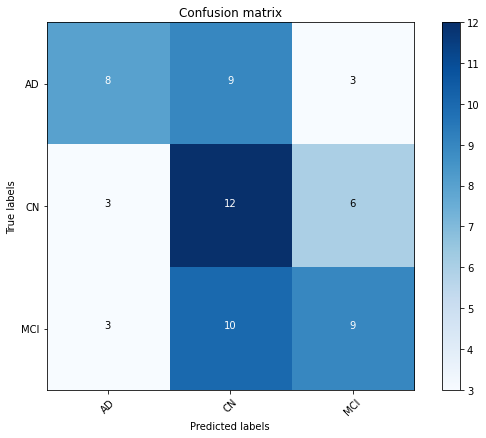

In [62]:
target_names = ('AD', 'CN', 'MCI')
plot_confusion_matrix(cm, target_names)

## Visualizar resultados del entrenamiento (Modelo afinado)

In [63]:
print(model.history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [64]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)
print(loss)
print(val_loss)

[0.38143364, 0.43496162, 0.48268762, 0.5042111, 0.5300393, 0.5433277, 0.55605465, 0.58207, 0.5964814, 0.60359347, 0.60883397, 0.62979597, 0.64551747, 0.65431404, 0.6591802, 0.6745274, 0.6831368, 0.7055961, 0.7104623]
[0.33913043, 0.35256916, 0.37549406, 0.3881423, 0.41343874, 0.40237153, 0.42687747, 0.4418972, 0.4403162, 0.4418972, 0.4229249, 0.43794465, 0.4355731, 0.4339921, 0.43715414, 0.42529643, 0.39288536, 0.3897233, 0.39683795]
[1.0953653128366223, 1.0585255821880588, 1.0217645172766703, 0.9905323225439386, 0.9586675938385469, 0.9357601789952484, 0.9066862049072439, 0.8851472318741394, 0.8661377006939862, 0.8470306004586345, 0.8329858206395194, 0.8035788636026413, 0.779060646955739, 0.7524623735754672, 0.7417558749449871, 0.719901988022385, 0.702094513892949, 0.6737640182801943, 0.663682406373223]
[1.1077098813582593, 1.0986617479737348, 1.0873253059199477, 1.090992117960622, 1.0654847401333607, 1.0816069681813398, 1.066154112027386, 1.0624778589864416, 1.0501597298411873, 1.0565

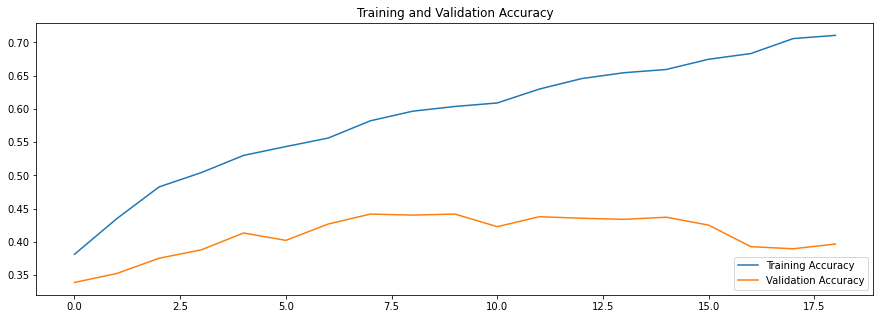

In [67]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(19)

plt.figure(figsize=(15, 5))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

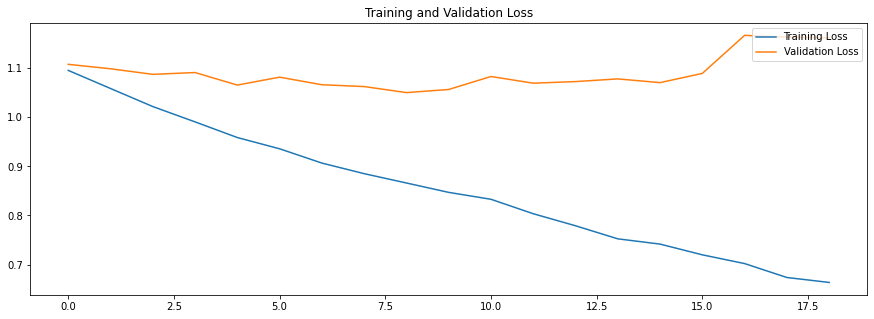

In [68]:
plt.figure(figsize=(15, 5))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
from sklearn.metrics import classification_report

y_true = test_batches.classes
y_pred = np.argmax(predictions, axis=-1)
target_names = ('AD', 'CN', 'MCI')

print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

          AD       0.57      0.40      0.47        20
          CN       0.39      0.57      0.46        21
         MCI       0.50      0.41      0.45        22

    accuracy                           0.46        63
   macro avg       0.49      0.46      0.46        63
weighted avg       0.49      0.46      0.46        63



# Referencias bibliográficas

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

https://github.com/tensorflow/tensorflow/issues/35515

<!-- GoogLeNet 
ILSVRC-2013 (Clarifai)
MSRA
Zeler & Fergus
OverFeat
Krizhevsky -->

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

https://towardsdatascience.com/alzheimer-diagnosis-with-deep-learning-a-survey-265406fa542a

https://www.youtube.com/watch?v=3V9YFPfgyAY

https://github.com/Yale-Deep-Learning-for-Alzheimers/Alzheimers-DL-Network

https://www.kaggle.com/code/muneebkhurram/alzheimer-mri-classification

0. Image Preparation for Convolutional Neural Networks with TensorFlow's Keras API
https://www.youtube.com/watch?v=_L2uYfVV48I&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

0.1 Data Augmentation with TensorFlow's Keras API
https://www.youtube.com/watch?v=WSvpLUietIM&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=14

1.Keras with TensorFlow - Data Processing for Neural Network Training
https://www.youtube.com/watch?v=3FwGDUD_ZuQ&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=3

2.Build and Train a Convolutional Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=3V9YFPfgyAY&t=326s

3.Keras with TensorFlow Prerequisites - Getting Started With Neural Networks
https://www.youtube.com/watch?v=e47ISlpYFok

4.Train a Fine-Tuned Neural Network with TensorFlow's Keras API
https://www.youtube.com/watch?v=TguZ0WK0orQ

5.Create a Confusion Matrix for Neural Network Predictions
https://www.youtube.com/watch?v=VYGVOwlT4oE&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=9

6.MobileNet Image Classification with TensorFlow's Keras API
https://www.youtube.com/watch?v=5JAZiue-fzY&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=19

7.Save and Load a Model with TensorFlow's Keras API
https://www.youtube.com/watch?v=8Nl-of5C3uA&list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL&index=10

https://keras.io/api/applications/

https://note.nkmk.me/python-tensorflow-keras-applications-pretrained-models/